# Stationarity in Time Series Data

| Key              | Value                                                                                                                                                                                                                                                                                                            |
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                                                                                                                                                                                            |
| **Course Names** | BBT 4206: Business Intelligence II (Week 7-9 of 13)<br>BFS 4102: Advanced Business Data Analytics (Week 7-9 of 13)                                                                                                                                                                                               |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                                          |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                                     |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                                           |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/RecommendedCitation.bib) |


### What is Stationarity?

A time series is said to be **stationary** if its statistical properties such as mean, variance, and autocorrelation are at least approximately the same over time. Most time series models require the data to be stationary. If the time series is not stationary, we need to transform it to a stationary series before we can apply the models.

A stationary time series has the following properties:

- The mean should fluctuate around the same value over time
- The variance should fluctuate around the same value over time
- The covariance should not depend on time: `Cov[X(t), X(t+h)]` depends only on `h`, not on `t`. For example, the relationship between a data point and the one immediately following it (lag of 1) should be the same whether it is in the year 2000 or 2020.
- The autocorrelation should fluctuate around the same value over time.

### Visual Indicators of Stationarity

We can visually inspect a time series plot to get an idea of whether it is stationary or not. Here are some visual cues:

- If there is a trend (upward or downward), the mean is not constant, and the series is not stationary.
- If the spread of the data changes over time, the variance is not constant, and the series is not stationary.
- There should be no seasonal patterns.

Let's load our data and visualize it to check for stationarity.

## Step 1: Import Libraries

**Purpose**: This chunk imports all the necessary libraries for data analysis, machine learning, and visualization.

1. **For file and system operations [urllib3](https://urllib3.readthedocs.io/en/stable/)**
    - `urllib.request` is used for opening and downloading data from URLs.
    - `os` provides functions for interacting with the operating system, such as file and directory management.

2. **For time seeries analysis - [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html):**
    - `pandas as pd`: For loading the dataset, creating and managing DataFrames, data manipulation and analysis using DataFrames
    - `numpy as np`: For numerical operations, array manipulations, and mathematical functions
    - `statsmodels.tsa.stattools import adfuller`: For performing the Augmented Dickey-Fuller (ADF) test to check for stationarity
    - `statsmodels.tsa.seasonal import seasonal_decompose`: For decomposing the time series into its components (trend, seasonality, residual)
    - `sklearn.linear_model import LinearRegression`: For fitting a linear regression model, useful for detrending the time series
    - `re`: For regular expressions, useful for string manipulation and cleaning

3. **For data visualization - [matplotlib](https://matplotlib.org/stable/gallery/index.html) and [seaborn](https://seaborn.pydata.org/examples/index.html)**
    - `matplotlib.pyplot as plt`: For basic plotting functionality
    - `mplfinance as mpf`: Specialized library for financial data visualization, particularly candlestick charts

4. **For suppressing warnings - [warnings](https://docs.python.org/3/library/warnings.html)**
    - `warnings`: Controls warning messages
    - `warnings.filterwarnings('ignore')`: Suppresses warning messages for cleaner output
    - Used to suppress warnings that may arise during the execution of the code. Even though it is not necessary for the code to run, it helps in keeping the output clean and focused on the results.

In [1]:
# For file and system operations
import urllib.request
import os

# For time series analysis
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Ensures that matplotlib plots are displayed directly within the notebook,
# right below the code cell that produces them. It makes visualizations appear
# inline for easier viewing and analysis.
%matplotlib inline

## Step 2: Load and Preprocess/Clean the Data

### Load the Data

In [5]:
dataset_path = './data/stockprice_cleaned.csv'

if not os.path.exists(dataset_path):
    print("❌ Please create the dataset first using the previous Jupyter Notebook.")
else:
    print("✅ Dataset exists locally")

data = pd.read_csv(dataset_path, encoding='utf-8', nrows=200000)

✅ Dataset exists locally


In [4]:
# Create the data directory if it doesn't exist
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Created directory: {data_dir}")
else:
    print(f"Directory already exists: {data_dir}")

# Define the URL of the dataset
dataset_url = "https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/main/data/stockprice_cleaned.csv"

# Define the local path where the dataset will be saved
dataset_path = os.path.join(data_dir, 'stockprice_cleaned.csv')

# Check if the file already exists locally
if not os.path.exists(dataset_path):
    print(f"Downloading dataset from {dataset_url}...")
    try:
        urllib.request.urlretrieve(dataset_url, dataset_path)
        print("Download complete.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
else:
    print("Dataset already exists locally.")

Created directory: ./data
Download complete.


### Preprocess/Clean the Data

In [6]:
# 1) Ensure datetime index and sorted

# This line converts the `Date` column in the `data` DataFrame to datetime
# objects. The `errors="coerce"` argument means that any value that cannot
# be parsed as a date will be replaced with `NaT` (Not a Time), which is
# pandas' way of marking missing or invalid dates. This helps prevent errors
# from invalid date formats and ensures the column is consistently typed.
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
    data = data.set_index("Date")

data = data.sort_index()

# 2) Normalize column names (trim, unify, and fix common naming)
data.columns = [c.strip() for c in data.columns]
rename_map = {
    "Close/Last": "Close",
    "Adj Close": "Close",
    "Adj. Close": "Close",
    "Closing Price": "Close",
    "Open Price": "Open",
    "Opening Price": "Open",
    "High Price": "High",
    "Low Price": "Low",
    "Trade Volume": "Volume",
    "Volume (Shares)": "Volume",
    "Total Volume": "Volume",
    "High/Low": "High",
    "Low/High": "Low"
}
data = data.rename(columns=rename_map)

# 3) Define a helper to strip non-numeric characters (keep digits, dot, minus)
def to_numeric_str(s: str) -> str:
    # Handle None/NaN safely
    s = "" if s is None else str(s)
    # Strip any characters except digits, decimal point, minus
    return re.sub(r"[^0-9.\-]", "", s)

# 4) Coerce OHLC to float
ohlc_cols = [c for c in ["Open", "High", "Low", "Close"] if c in data.columns]
for c in ohlc_cols:
    data[c] = pd.to_numeric(data[c].astype(str).map(to_numeric_str), errors="coerce")

# 5) Coerce Volume to numeric (basic version: strip non-numeric)
if "Volume" in data.columns:
    data["Volume"] = pd.to_numeric(data["Volume"].astype(str).map(to_numeric_str), errors="coerce")

# Optional: if your Volume has K/M/B suffixes (e.g., 12K, 3.5M, 1.2B) and you want correct scaling:
def parse_volume(v):
    v = str(v).strip()
    if not v or v.lower() == "nan":
        return float("nan")
    mult = 1
    if v[-1] in "KkMmBb":
        suffix = v[-1].upper()
        v = to_numeric_str(v[:-1])
        mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}[suffix]
    else:
        v = to_numeric_str(v)
    return float(v) * mult if v else float("nan")
if "Volume" in data.columns:
    data["Volume"] = data["Volume"].map(parse_volume)

# 6) Drop rows where any of OHLC are missing (mplfinance needs valid OHLC rows)
if ohlc_cols:
    data = data.dropna(subset=ohlc_cols)

### Confirm Cleaned Data

In [7]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())


*1* The number of observations and variables


(452, 5)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2024-01-02 to 2025-10-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   452 non-null    float64
 1   High    452 non-null    float64
 2   Low     452 non-null    float64
 3   Open    452 non-null    float64
 4   Volume  452 non-null    float64
dtypes: float64(5)
memory usage: 21.2 KB


None

In [8]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())


*3* The summary of the numeric columns:


,Close,High,Low,Open,Volume
count,452.000000,452.000000,452.000000,452.000000,4.520000e+02
mean,124.595076,126.704027,122.227723,124.603305,3.115069e+08
std,33.117433,33.323281,32.944227,33.226029,1.559501e+08
min,47.545158,48.159848,47.296283,47.461201,1.051570e+08
25%,104.410442,106.551896,101.227312,104.428028,1.931445e+08
50%,125.023098,128.152287,122.289471,124.838505,2.659380e+08
75%,141.944962,144.298532,140.352258,142.476957,3.982077e+08
max,192.570007,195.619995,191.059998,193.509995,1.142269e+09



*4* The whole dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072392,49.522167,48.281788,48.437711,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0
...,...,...,...,...,...
2025-10-14,180.029999,184.800003,179.699997,184.770004,205641400.0
2025-10-15,179.830002,184.869995,177.289993,184.800003,214450500.0
2025-10-16,181.809998,183.279999,179.770004,182.229996,179723300.0



*5* The first 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072392,49.522167,48.281788,48.437711,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0



*6* The last 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2025-10-14,180.029999,184.800003,179.699997,184.770004,205641400.0
2025-10-15,179.830002,184.869995,177.289993,184.800003,214450500.0
2025-10-16,181.809998,183.279999,179.770004,182.229996,179723300.0
2025-10-17,183.220001,184.100006,179.750000,180.179993,173135200.0
2025-10-20,182.639999,185.199997,181.729996,183.130005,128208800.0


## Step 3: Plot the Data

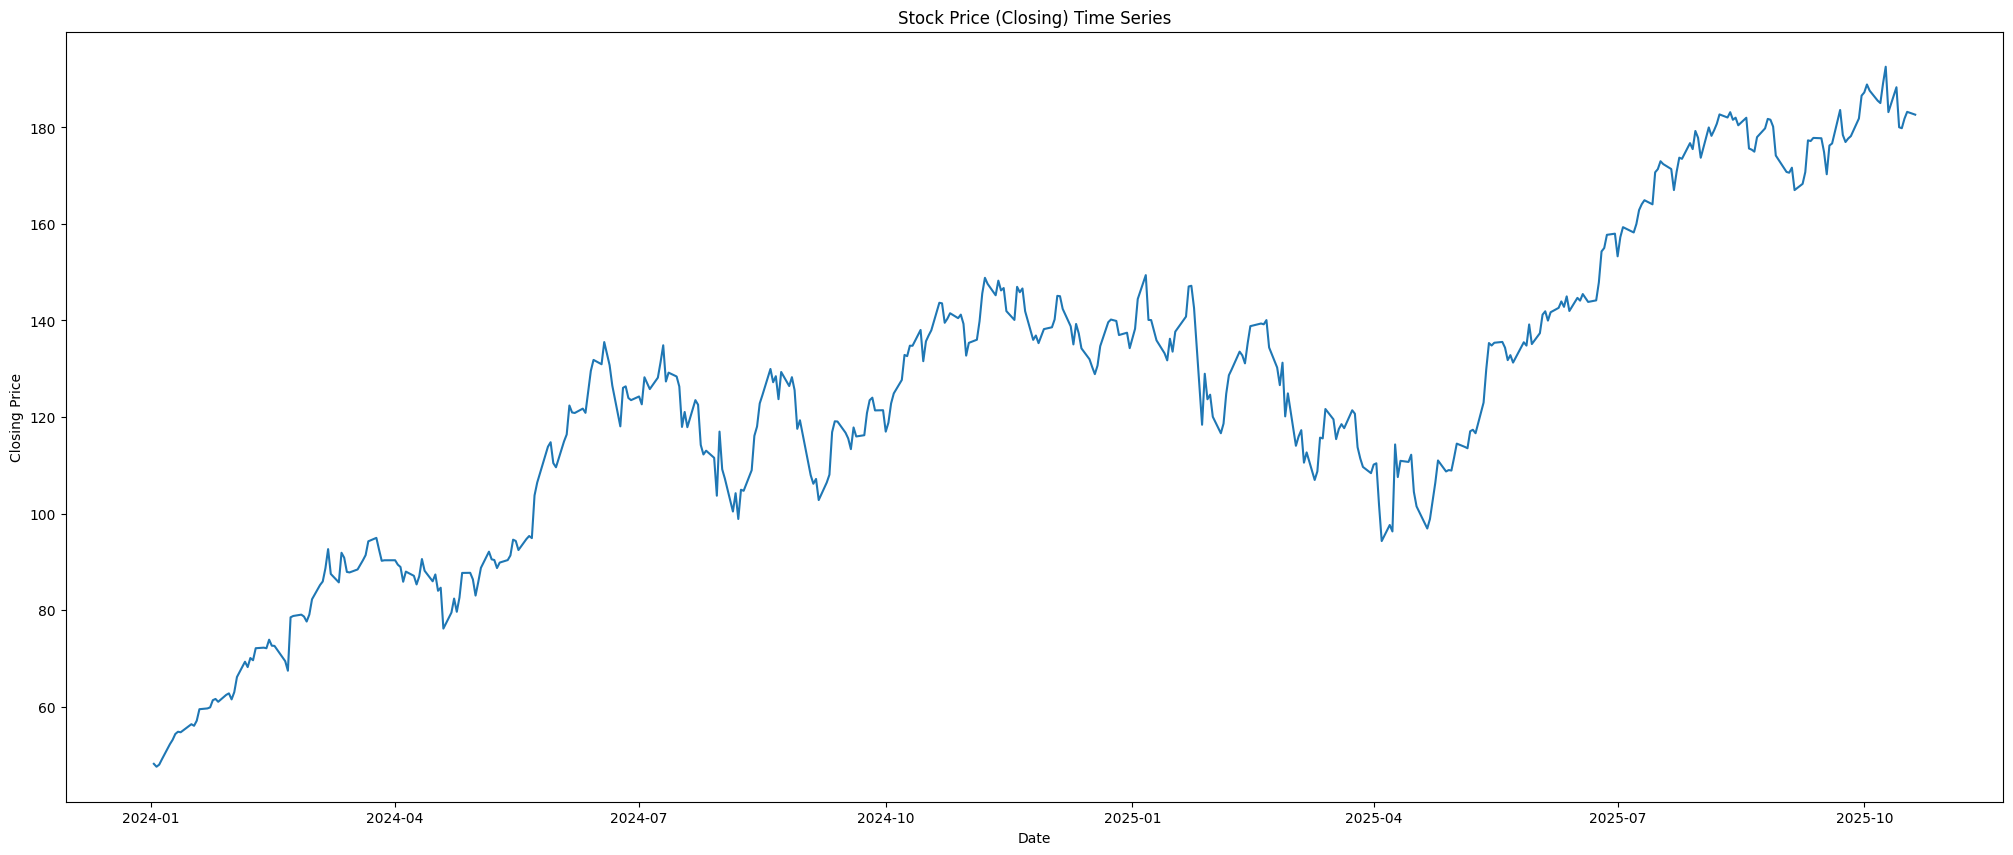

In [9]:
plt.figure(figsize=(25, 10))
plt.plot(data["Close"])
plt.title(f"Stock Price (Closing) Time Series")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

## Step 4: Decompose the Time Series into its Components
Decomposing a time series helps us understand its components: trend, seasonality, and residuals (or irregular component). This can provide insights into the underlying patterns in the data.
We can use the `seasonal_decompose` function from `statsmodels` to decompose the time series. The decomposition can be either additive or multiplicative.
- **Additive Decomposition:** The time series is expressed as the sum of its components: `Y(t) = Trend(t) + Seasonality(t) + Residual(t)`
- **Multiplicative Decomposition:** The time series is expressed as the product of its components: `Y(t) = Trend(t) * Seasonality(t) * Residual(t)`. Multiplicative decomposition requires all values to be positive.
- **Trend:** The long-term movement in the data.
- **Seasonality:** The repeating short-term cycle in the data.
- **Residual (Irregularity):** The random noise or irregular component in the data that cannot be explained by the trend or seasonality.
- **Cycle:** A long-term oscillation in the data that is not necessarily seasonal. It can be thought of as a longer-term trend that fluctuates around a mean value. The cycle is often included in the residual if the decomposition is additive, as it captures long-term fluctuations that are not seasonal.

**Period in Decomposition**
- `period` is the number of observations per full seasonal cycle.
- seasonal_decompose needs **at least two full cycles** in your data: `len(series) >= 2 × period`
  - Example: If you set period = 252 or 365 but do not have at least ≈504 or ≈730 observations respectively, the decomposition will raise an error.
- The ideal period depends on the cycle you want to capture and the sampling used when collecting the data. Common values for stock price include:
  - Weekly trading cycle (business days): `period = 5`
  - Monthly trading cycle: `period ≈ 21` (average trading days in a month)
  - Quarterly trading cycle: `period ≈ 63` (21 trading days per month x 3 months)
  - Annual trading cycle: `period ≈ 252` (trading days/year)
  - Calendar daily data (inclusive of weekends and public holidays): `period = 7` (weekly), `period = 365` (annual)


Model used to decompose: multiplicative
Detected frequency in the time series data is: None


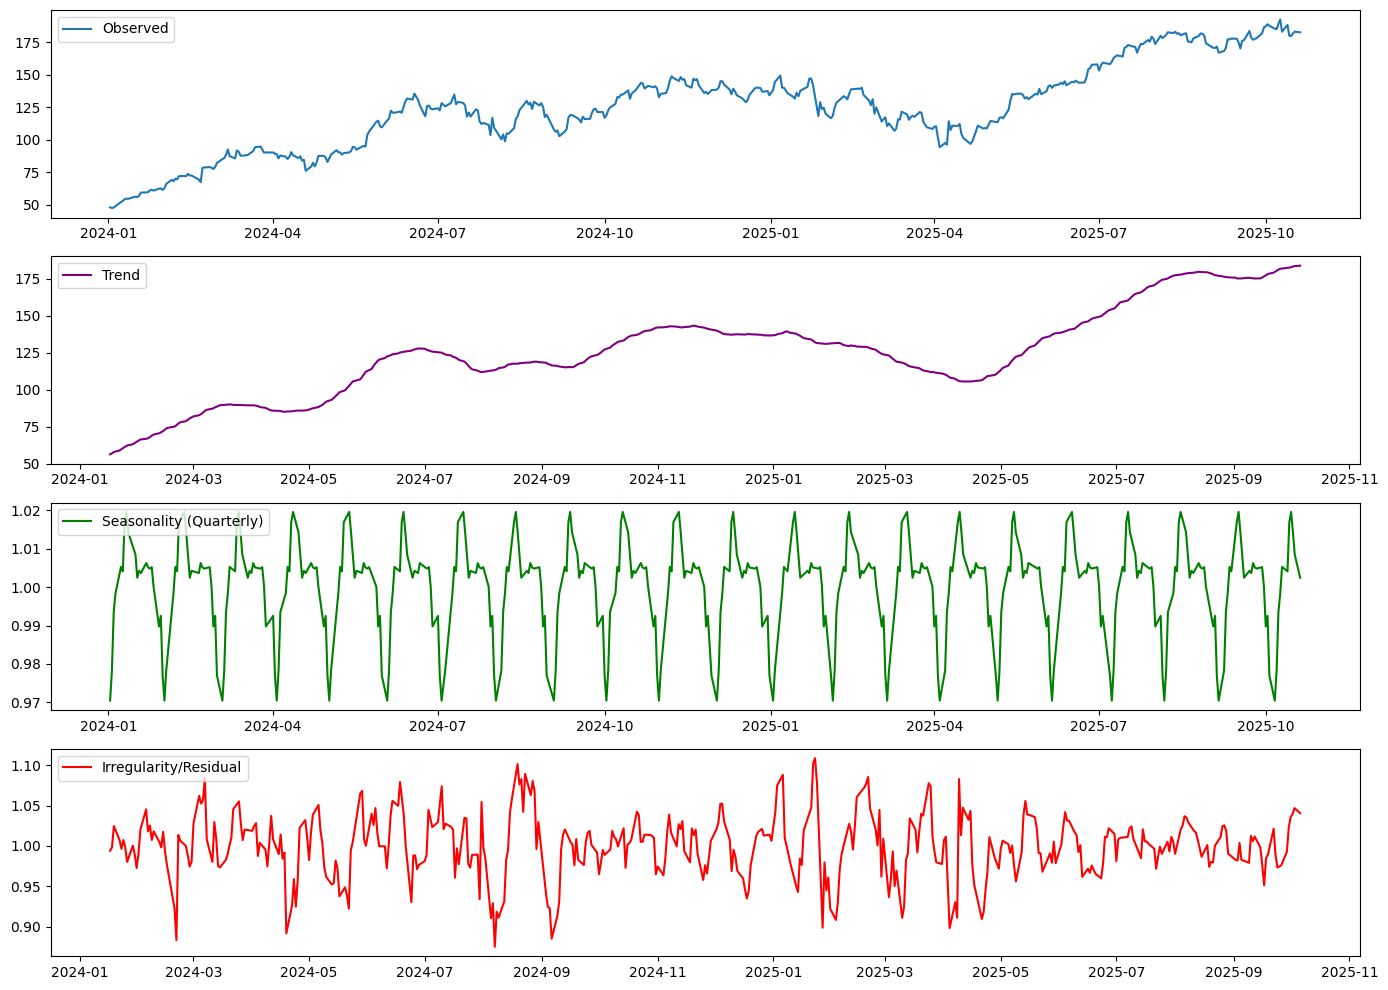

In [10]:
# If data is already a Series, it uses it directly.
# If data is a DataFrame, it selects the Close column and converts it to float64.
ts = data if isinstance(data, pd.Series) else data["Close"].astype('float64')

# Ensure DateTimeIndex and set/keep frequency if possible
if not isinstance(ts.index, pd.DatetimeIndex):
    raise ValueError("Time series index must be a DateTimeIndex for seasonal decomposition.")
# Try to infer frequency if not present
if ts.index.freq is None:
    inferred = pd.infer_freq(ts.index)
    if inferred is not None:
        ts = ts.asfreq(inferred)

# Decide model safely: multiplicative requires strictly positive values
model_to_use = 'multiplicative' if (ts > 0).all() else 'additive'

print("Model used to decompose:", model_to_use)

# Choose a sensible seasonal period based on frequency and desired cycle
# Set which seasonal cycle you want to capture: 'weekly' (trading week) or 'annual' (trading year)
seasonality_target = 'weekly'  # or 'annual'

period = 21  # fallback default
if ts.index.freq is not None:
    freqstr = ts.index.freqstr.upper()
    if 'B' in freqstr:  # Business-day frequency (weekdays only)
        period = 5 if seasonality_target == 'weekly' else 252
    elif 'M' in freqstr:  # Monthly
        period = 12
    elif 'W' in freqstr:  # Weekly
        period = 52
    elif 'Q' in freqstr:  # Quarterly
        period = 4
    elif 'D' in freqstr:  # Calendar daily (weekends included)
        period = 7 if seasonality_target == 'weekly' else 365

print("Detected frequency in the time series data is:", ts.index.freq)

# Decompose the time series
decomposition = seasonal_decompose(ts, model=model_to_use, period=period)

# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='purple')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality (Quarterly)', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Irregularity/Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Step 5: Statistical Tests of Stationarity

Visual inspection can be subjective. Therefore, we use statistical tests to check for stationarity. One of the most commonly used tests is the **Augmented Dickey-Fuller (ADF) test**.

The ADF test is a statistical test for the following hypothesis:

* **Null Hypothesis (H0):** The time series is non-stationary.
* **Alternative Hypothesis (H1):** The time series is stationary.

We interpret the result of the ADF test using the p-value. If the p-value is less than a significance level (e.g., p<.05), we reject the null hypothesis and conclude that the time series is stationary.

In [11]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'Augmented Dickey-Fuller (ADF) Statistic: {result[0]}')
    # for key, value in result[4].items():
    #     print('Critial Values:')
    #     print(f'   {key}, {value}')
    print(f'p-value: {result[1]}')

adf_test(ts)

Augmented Dickey-Fuller (ADF) Statistic: -1.6493493036143114
p-value: 0.4573798043289457


If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is non-stationary. In this case, we need to make the series stationary. A common way to do this is by **differencing** the series.

## Step 6: Stationarizing Techniques (Data Transformation)

#### Differencing: Taking first differences `(Y(t) - Y(t-1))`

In [12]:
# If the series is non-stationary, we can difference it
time_series_differenced = ts.diff().dropna()

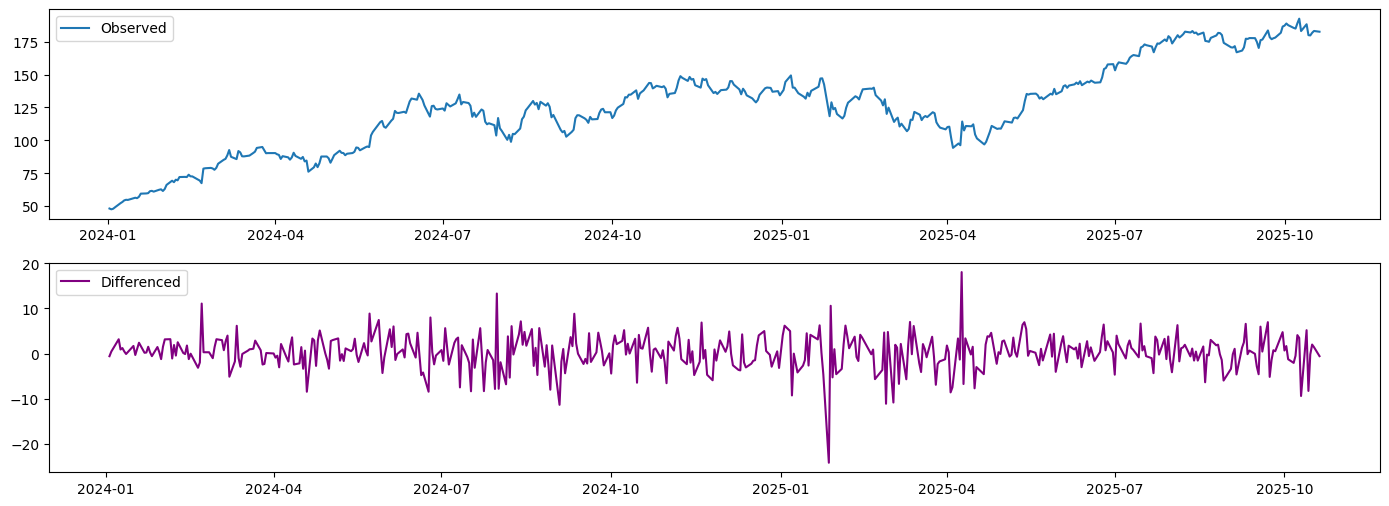

Augmented Dickey-Fuller (ADF) Statistic: -12.9435827390955
p-value: 3.493284436867227e-24


In [13]:
# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(time_series_differenced, label='Differenced', color = 'purple')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Perform ADF test on the differenced series
adf_test(time_series_differenced)

#### Detrending: Removing trend components

In [14]:
# Prepare the time index as a feature for regression
time_index = np.arange(len(ts)).reshape(-1, 1)

# Fit linear regression (trend)
lr = LinearRegression()
lr.fit(time_index, ts.values)
trend = lr.predict(time_index)

# Detrend the series
time_series_detrended = ts.values - trend

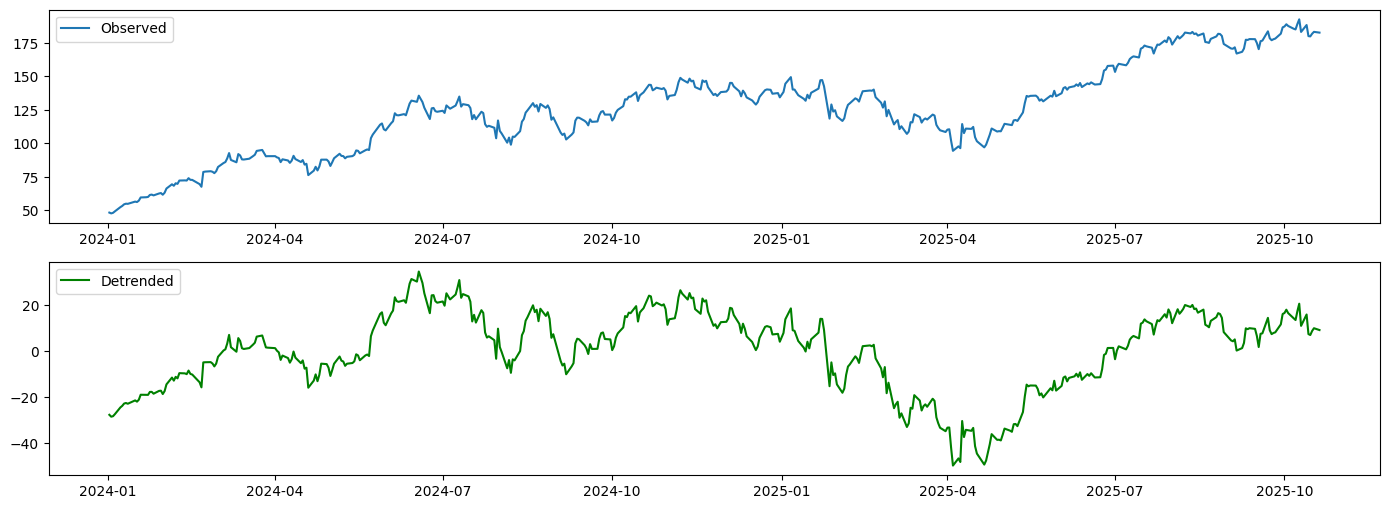

Augmented Dickey-Fuller (ADF) Statistic: -2.455753025685811
p-value: 0.12661449787401563


In [15]:
# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(ts.index, time_series_detrended, label='Detrended', color = 'green')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Perform ADF test on the detrended series
adf_test(time_series_detrended)

#### Log Transformation: For changing variance

In [16]:
# Apply log transformation (add a small constant if data contains zeros)
time_series_log_transformed = np.log(ts + 1e-8)

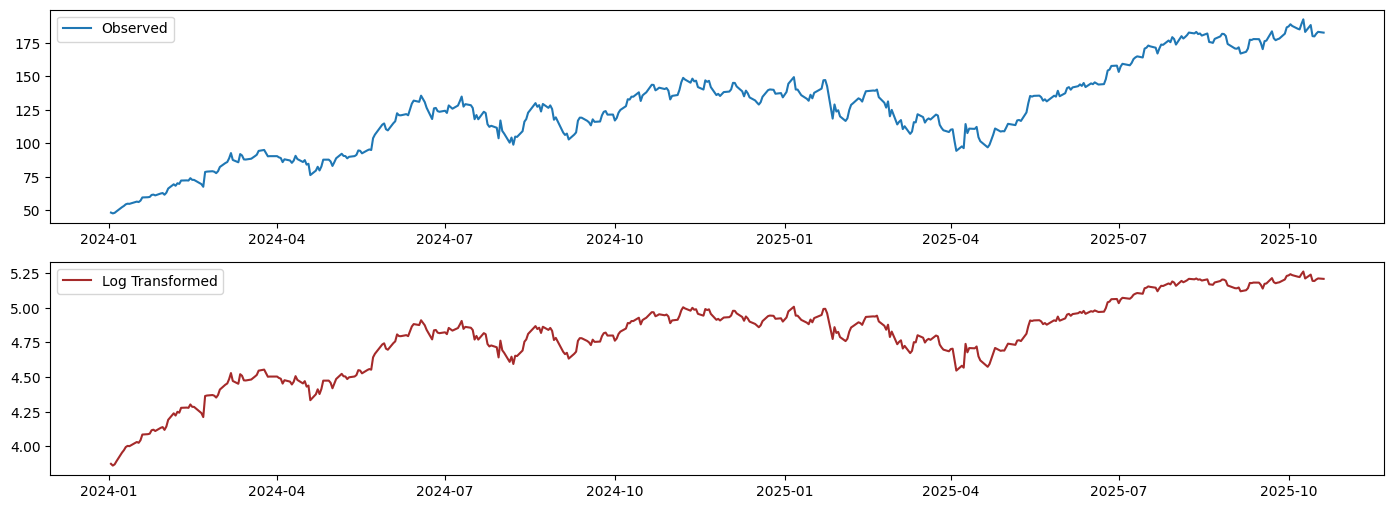

Augmented Dickey-Fuller (ADF) Statistic: -2.9058273201050637
p-value: 0.04467454375565929


In [17]:
# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(ts.index, time_series_log_transformed, label='Log Transformed', color = 'brown')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Perform ADF test on the detrended series
adf_test(time_series_log_transformed)

#### Seasonal Differencing: For seasonal patterns

In [18]:
# Seasonal differencing (e.g., period=12 for monthly data)
time_series_seasonal_differenced = ts.diff(63).dropna()

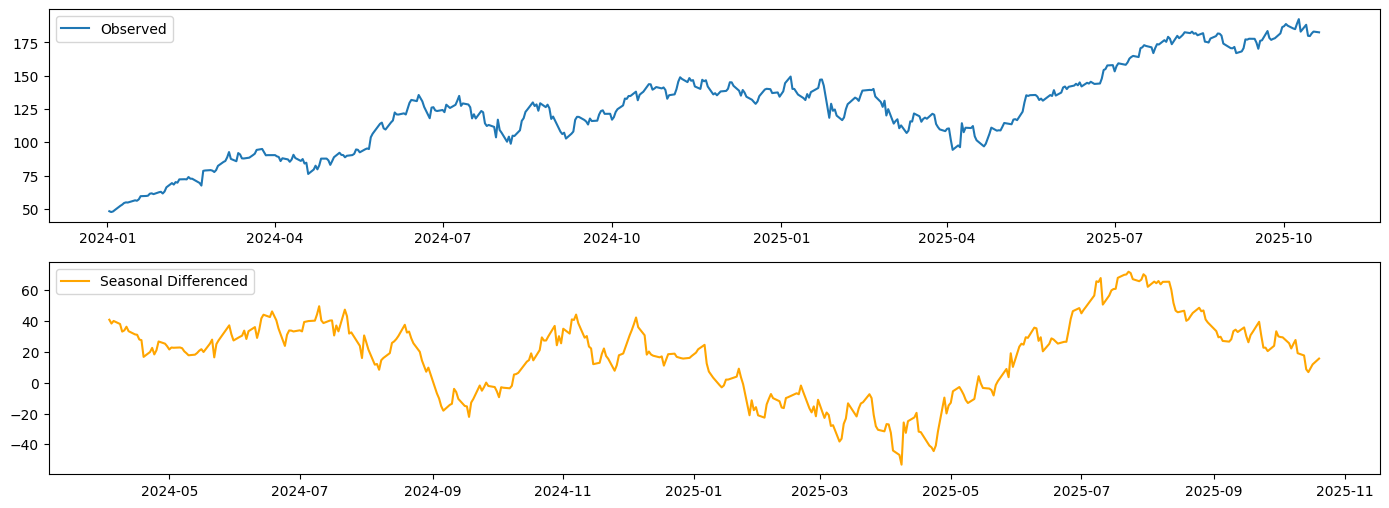

Augmented Dickey-Fuller (ADF) Statistic: -2.1343497830550637
p-value: 0.2309285145008073


In [19]:
# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(time_series_seasonal_differenced, label='Seasonal Differenced', color = 'orange')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Perform ADF test on the detrended series
adf_test(time_series_seasonal_differenced)

## In-Built Stationarizing Mechanism in Time Series Forecasting Algorithms
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
    - Exponential Smoothing techniques do not require the series to be stationary.
    - Instead, they explicitly model components such as trend and seasonality directly.
    - They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
    - ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
    - You specify the `d` parameter in `ARIMA(p, d, q)`, where:
        - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
    - SARIMA extends ARIMA with seasonal differencing.
    - It uses two differencing parameters:
        - `d` for non-seasonal differencing,
        - `D` for seasonal differencing over a defined period m.
    - Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
    - LSTM models do not have explicit stationarizing mechanisms.
    - They learn directly from raw sequences, even if they are non-stationary.
    - However, data preprocessing such as normalization and differencing often improves performance.
    - LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.